# Football Analytics with Data Revolution

### Using [Football Statsbomb Data] from *FA Women's Super League*

### Objectives:
1. Downloading and Parsing Football Data JSON File
2. Basic Pass Map Visualization
3. Pass Classification using KMeans Clustering
4. Pass Sequence Prediction using LSTM
5. Evaluate the Predictability of Team Ball Movement

### Python Dependances Include:
- *sklearn* for clustering
- *matplotlib* for visualization
- *keras* (and Tensorflow Backend) for neural network model
- *pandas* for data frame wrangling

[Football Statsbomb Data]: https://github.com/statsbomb/open-data "Statsbomb Open Data Github Repository"

## 1. Downloading and Parsing Football Data JSON File

In [ ]:
import requests

### Football's competition 37

In [ ]:
import re, json, requests

url = 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/37/4.json'

resp = requests.get(url)
resp_parsed = re.sub(r'^jsonp\d+\(|\)\s+$', '', resp.text)
football = json.loads(resp_parsed)

### A list comprehension is the same as doing this:

In [ ]:
mat_id = [f['match_id'] for f in football]

#### No of Games

In [ ]:
print("There are {} games in this list".format(len(mat_id)))

There are 108 games in this list


### Football Data Display

In [ ]:
import pandas as pd
pd.DataFrame.from_dict(football[0])

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,metadata,match_week,competition_stage,stadium,referee
competition_id,7298,2018-02-24,20:45:00.000,37,NaN,NaN,NaN,2,2,available,scheduled,2022-05-27T12:02:24.272045,2021-06-13T16:17:31.694,NaN,0,NaN,NaN,NaN
country_name,7298,2018-02-24,20:45:00.000,England,NaN,NaN,NaN,2,2,available,scheduled,2022-05-27T12:02:24.272045,2021-06-13T16:17:31.694,NaN,0,NaN,NaN,NaN
competition_name,7298,2018-02-24,20:45:00.000,FA Women's Super League,NaN,NaN,NaN,2,2,available,scheduled,2022-05-27T12:02:24.272045,2021-06-13T16:17:31.694,NaN,0,NaN,NaN,NaN
season_id,7298,2018-02-24,20:45:00.000,NaN,4,NaN,NaN,2,2,available,scheduled,2022-05-27T12:02:24.272045,2021-06-13T16:17:31.694,NaN,0,NaN,NaN,NaN
season_name,7298,2018-02-24,20:45:00.000,NaN,2018/2019,NaN,NaN,2,2,available,scheduled,2022-05-27T12:02:24.272045,2021-06-13T16:17:31.694,NaN,0,NaN,NaN,NaN
home_team_id,7298,2018-02-24,20:45:00.000,NaN,NaN,746,NaN,2,2,available,scheduled,2022-05-27T12:02:24.272045,2021-06-13T16:17:31.694,NaN,0,NaN,NaN,NaN
home_team_name,7298,2018-02-24,20:45:00.000,NaN,NaN,Manchester City WFC,NaN,2,2,available,scheduled,2022-05-27T12:02:24.272045,2021-06-13T16:17:31.694,NaN,0,NaN,NaN,NaN
home_team_gender,7298,2018-02-24,20:45:00.000,NaN,NaN,female,NaN,2,2,available,scheduled,2022-05-27T12:02:24.272045,2021-06-13T16:17:31.694,NaN,0,NaN,NaN,NaN
home_team_group,7298,2018-02-24,20:45:00.000,NaN,NaN,None,NaN,2,2,available,scheduled,2022-05-27T12:02:24.272045,2021-06-13T16:17:31.694,NaN,0,NaN,NaN,NaN
country,7298,2018-02-24,20:45:00.000,NaN,NaN,"{'id': 68, 'name': 'England'}","{'id': 68, 'name': 'England'}",2,2,available,scheduled,2022-05-27T12:02:24.272045,2021-06-13T16:17:31.694,NaN,0,NaN,"{'id': 68, 'name': 'England'}","{'id': 68, 'name': 'England'}"


#### Match Identity

In [ ]:
mat_id[:5]

[7298, 19778, 19771, 19736, 19745]

### Build a Python Class for Handling Pass Football Data

In [ ]:
class Pass(object):
    def __init__(self, **kwargs):            
        for key, value in kwargs.items():
            setattr(self, key, value)
    
    # This method is useful later for creating training data for clustering
    def vector(self):
        return [self.x, self.end_x, self.y, self.end_y]

#### Example Pass Object Instance

In [ ]:
example_pass = Pass(**{"team":"West Ham United LFC", "x":53.0, "analyst":"Olli Harder", "etc":"..."})

####  allows you to pass keyworded variable length of arguments to a function

In [ ]:
print(example_pass)

### Template URL at which each game's event data is stored

In [ ]:
da_sor = {}

mat_da_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{}.json"

# This takes some time, naturally
for m in mat_id:
    
    # Empty List for each game
    da_sor[m] = []
    
    # Get all events from a particular game
    all_events = requests.get(url=mat_da_url.format(m)).json()
    
    # Filter them by type-name Pass
    passes = [x for x in all_events if x['type']['name'] == "Pass"]
    for p in passes:
                
        # Store attributes in dictionary
        attr_but = {
            "team": p["possession_team"]["name"],
            "possession_id": p["possession"],
            "x": p['location'][0],
            "y": p['location'][1],
            "end_x": p['pass']['end_location'][0],
            "end_y": p['pass']['end_location'][1]
        }
        
        # Construct Pass object from attribute keywords and store
        da_sor[m].append(Pass(**attr_but))

## 2. Basic Pass Map Visualization

In [ ]:
import matplotlib.pyplot as plt

### Nice trick for high-resolution figures on retina screen

In [ ]:
%config InlineBackend.figure_format = 'retina'

### Plot all passes from single game

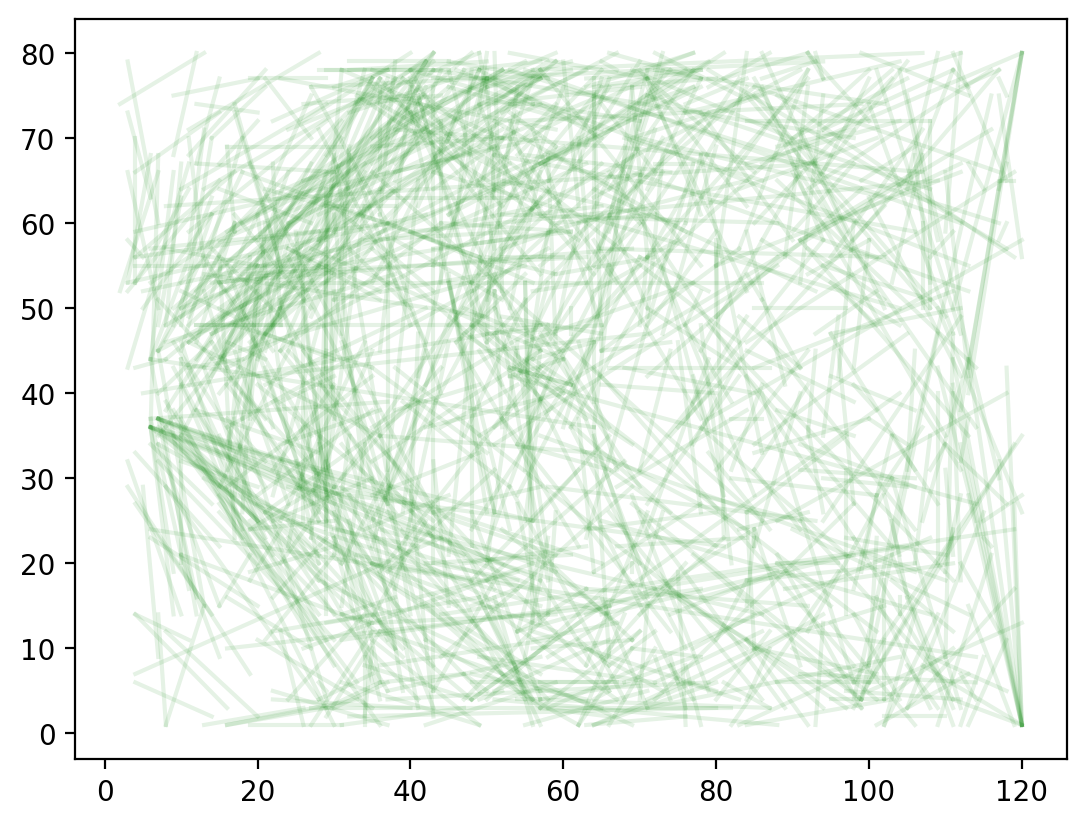

In [ ]:
match = 19783  # Chelsea FCW vs Everton LFC

for p in [p for p in da_sor[match]]:
    plt.plot([p.x, p.end_x],[p.y, p.end_y], c='green', alpha=0.1)
plt.show()

## 3. Pass Classification using KMeans Clustering

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
np.random.seed(42)

### Create training data for clustering

In [ ]:
train_data = []
for match_id, passes in da_sor.items():
    for p in passes:
        # For each pass, use the vector method
        train_data.append(p.vector())

### Perform the clustering on the training data

In [ ]:
# 49 is mostly arbitrary, first index is used for end-of-sequence in later analysis
cluster_model = KMeans(n_clusters=49).fit(train_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Cluster Model Centroid

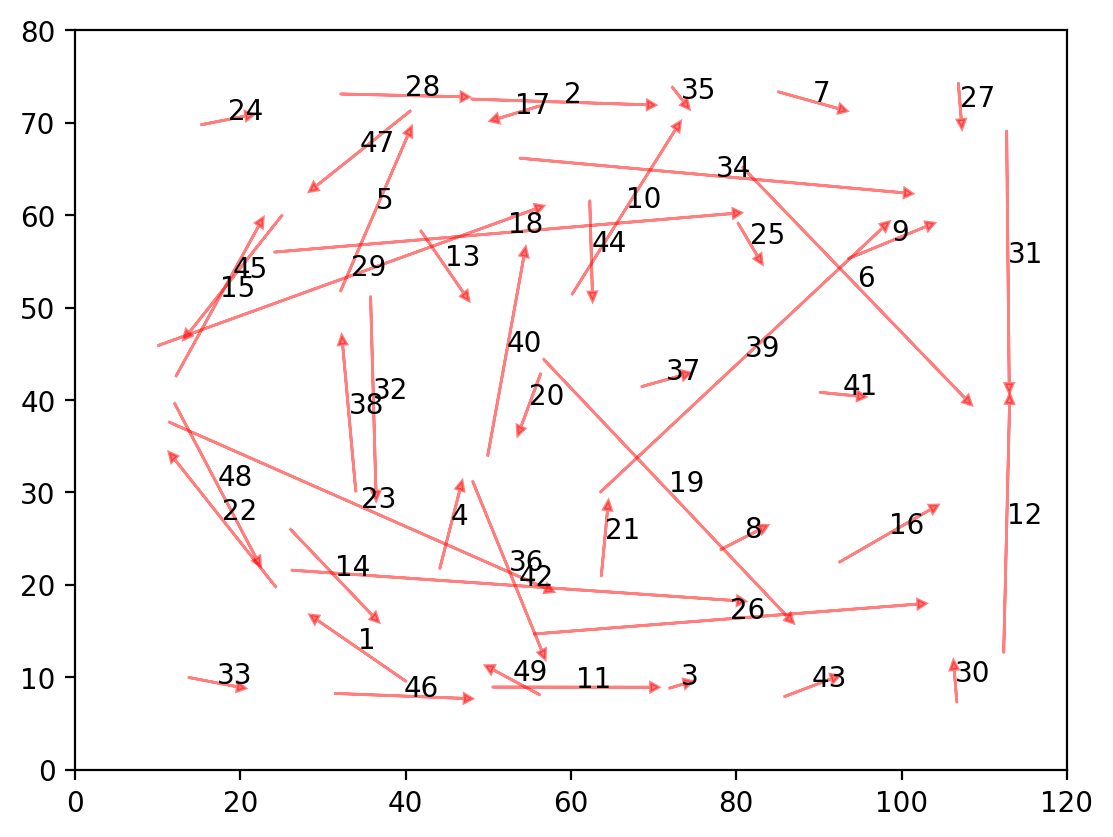

In [ ]:
for i, (x, end_x, y, end_y) in enumerate(cluster_model.cluster_centers_):
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=1,
              head_length=1,
              color='red',
              alpha=0.5,
              length_includes_head=True)
    
    plt.text((x+end_x)/2, (y+end_y)/2, str(i+1))
    
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

In [ ]:
for match_id, passes in da_sor.items():
    for p in passes:
        # evaluate pass vector and make pass_cluster prediction
        # We add +1 to reserve index 0 for sequence modeling later
        pas_clus = cluster_model.predict([p.vector()])[0] + 1
        
        # Set pass_cluster attribute on pass object
        setattr(p, "pass_cluster", pas_clus)

## 4. Pass Sequence Prediction using LSTM

In [ ]:
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential

### Construct Training Data

In [ ]:
X_Train = []
Y_Train = []

# For Use Later
Team_lab = []

for mat_i, passes in da_sor.items():
    
    # Find Unique Possessions in pass data
    possessions = set([p.possession_id for p in passes])
    
    # For each possession, create a list of pass clusters inside it
    for possession_id in possessions:
        sequence = [[p.pass_cluster, p.team] for p in passes if p.possession_id == possession_id]
        sequence.append([0, None])
        
        # Create subsequences and trim/pad sequences to five (5) passes
        # TODO Make a graphic for this, since it's confusing
        for i in range(4 if len(sequence) > 5 else len(sequence) - 1):
            adj_seq = []
            target = sequence[i+1][0]
            for j in range(0,4):
                adj_seq.append(sequence[j][0] if j <= i else 0)
            adj_seq.append(0)
            
            X_Train.append(np.array(adj_seq).reshape(5,1))
                        
            # One-hot encoding for target classification
            Y_Train.append([1 if k == target else 0 for k in range(0,50)])
            Team_lab.append(sequence[i+1][1])
            

### Build Sequential Neural Network

In [ ]:
model = Sequential()

# Add LSTM to Model
model.add(LSTM(200, input_shape=(5,1)))

### The Final Layer has a shape equal to the number of clusters

In [ ]:
model.add(Dense(50, activation='softmax'))

# Compile using loss of Categorical Crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam')

#### Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 50)                10050     
                                                                 
Total params: 171,650
Trainable params: 171,650
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [ ]:
X_Train1 = np.array(X_Train)
Y_Train1 = np.array(Y_Train)
model.fit([X_Train1], [Y_Train1], epochs=15, batch_size=50, verbose=1)

Epoch 1/15
1225/1225 [==============================] - 31s 23ms/step - loss: 3.4914
Epoch 2/15
1225/1225 [==============================] - 31s 26ms/step - loss: 3.3863
Epoch 3/15
1225/1225 [==============================] - 25s 20ms/step - loss: 3.2612
Epoch 4/15
1225/1225 [==============================] - 24s 20ms/step - loss: 3.1557
Epoch 5/15
1225/1225 [==============================] - 24s 20ms/step - loss: 3.0827
Epoch 6/15
1225/1225 [==============================] - 25s 21ms/step - loss: 3.0251
Epoch 7/15
1225/1225 [==============================] - 24s 20ms/step - loss: 2.9810
Epoch 8/15
1225/1225 [==============================] - 28s 23ms/step - loss: 2.9392
Epoch 9/15
1225/1225 [==============================] - 25s 21ms/step - loss: 2.9071
Epoch 10/15
1225/1225 [==============================] - 25s 21ms/step - loss: 2.8815
Epoch 11/15
1225/1225 [==============================] - 24s 20ms/step - loss: 2.8546
Epoch 12/15
1225/1225 [==============================] - 24s 20

### Make Prediction on sequence

1/1 [==============================] - 0s 484ms/step


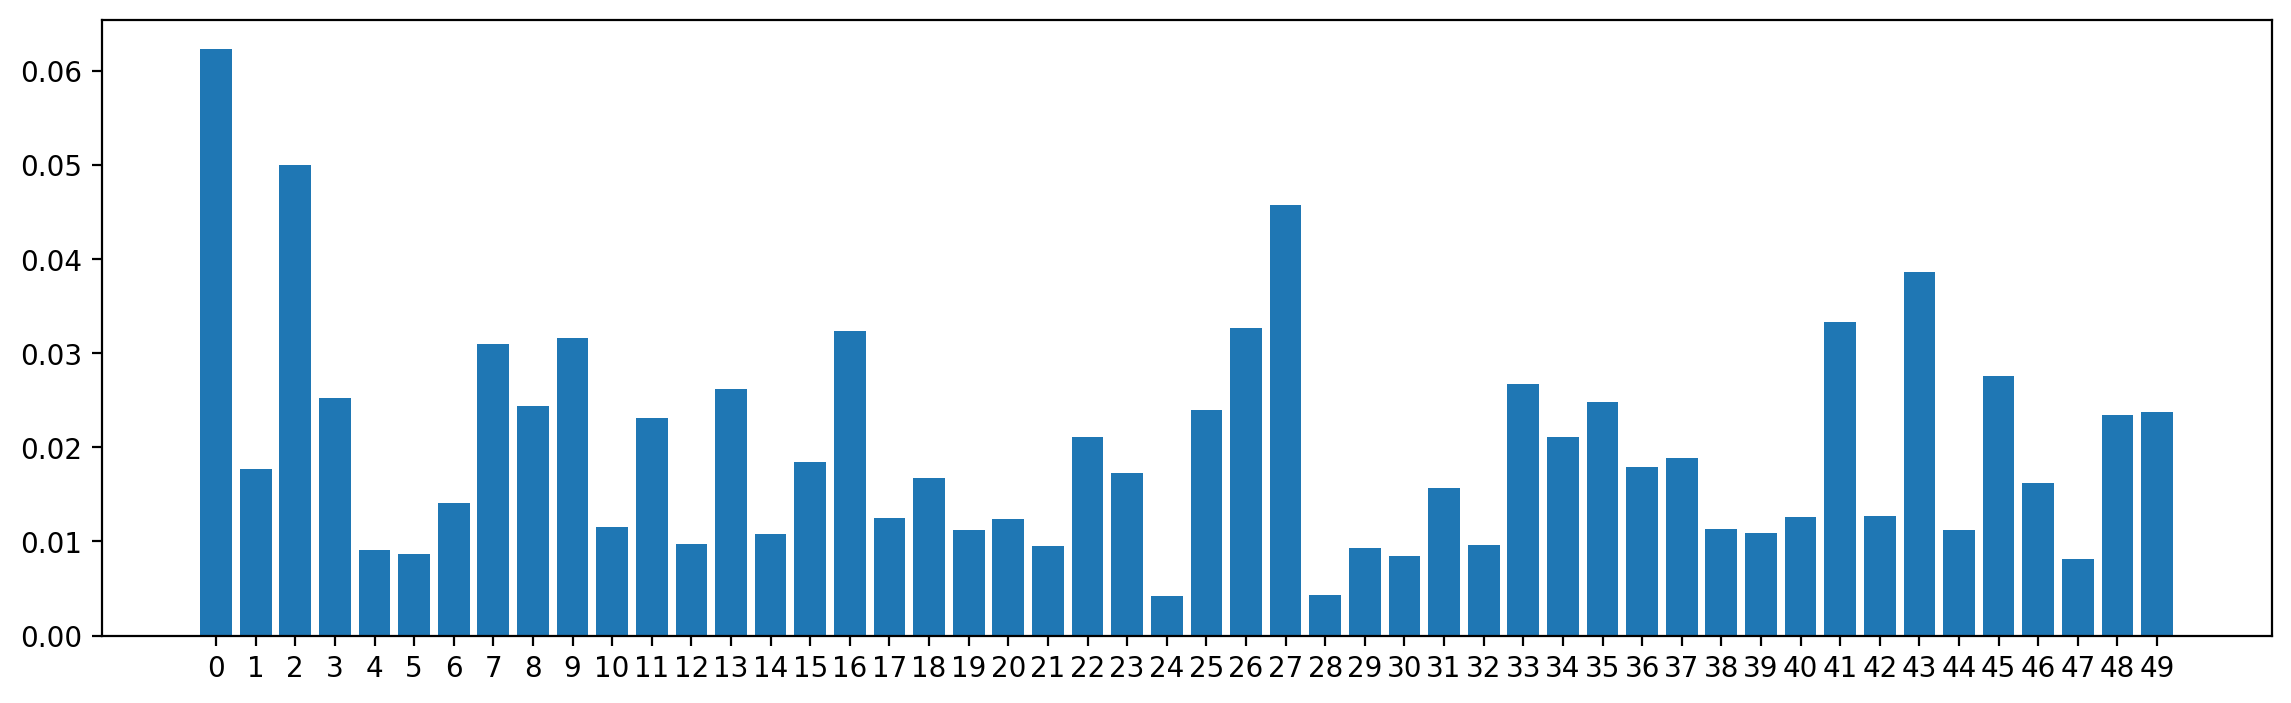

In [ ]:
sequence = [30,0,0,0,0]
predictions = model.predict([[np.array(sequence).reshape(5,1)]])[0]

plt.figure(figsize=(14,4))
plt.bar(range(0,50), predictions, tick_label=[str(i) for i in range(50)])
plt.show()

# This makes intuitive sense when you look back at pass cluster map.

### Plot Possession Sequence, and Likely Next Passes

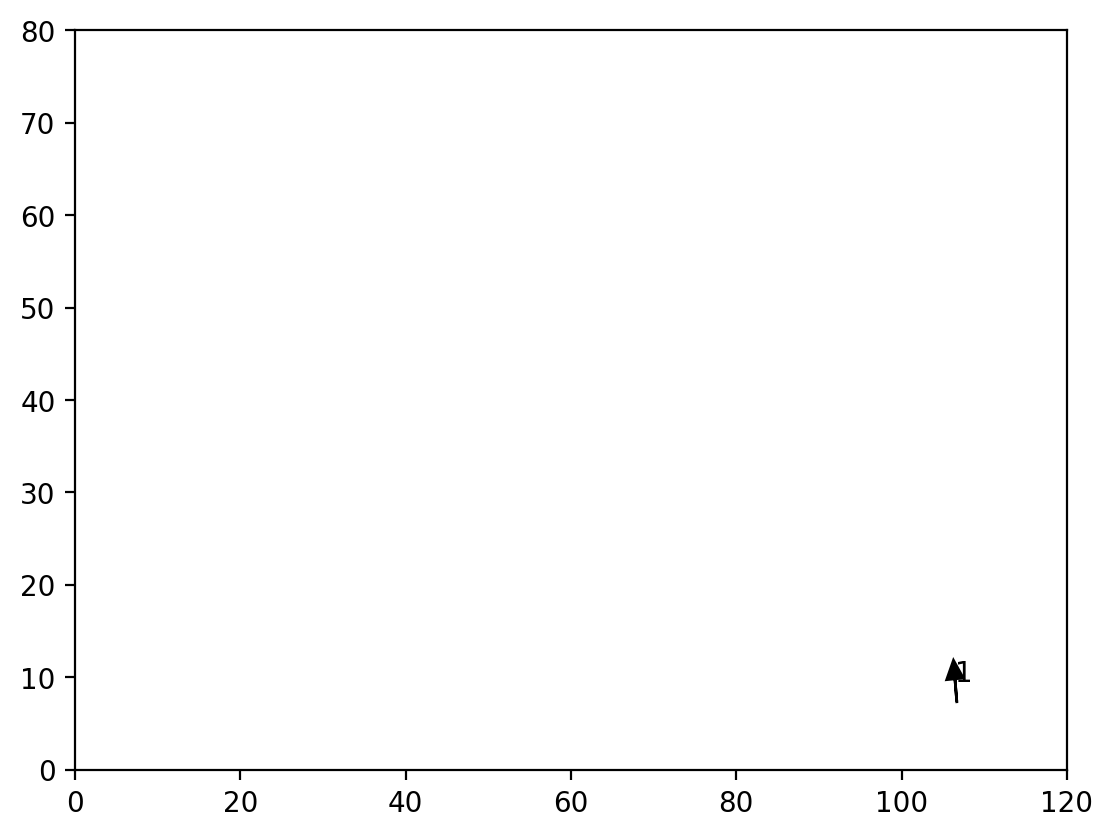

In [ ]:
for i, (x, end_x, y, end_y) in enumerate([cluster_model.cluster_centers_[i-1] for i in sequence if i > 0]):    
    
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=2,
              head_length=2,
              color='black',
              length_includes_head=True)
    
    plt.text((x+end_x)/2, (y+end_y)/2, str(i+1))
    
for i, (x, end_x, y, end_y) in enumerate(cluster_model.cluster_centers_):
    
    if predictions[i+1] > 0.1:    
        plt.arrow(x, y, end_x-x, end_y-y,
                  head_width=2,
                  head_length=2,
                  color='red',
                  alpha=0.5,
                  length_includes_head=True)
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

## 5. Evaluate Team Ball Movement

In [ ]:
import pandas as pd

In [ ]:
Team_lis = {x:{"passes":0, "likely_passes":0} for x in set(Team_lab)}

### (It's running predictions on entire data set)

In [ ]:
# This takes a minute or two
for i, e in enumerate(X_Train):
        
    Pas_typ = Y_Train[i].index(1)
    Predict = list(model.predict([[e]])[0])
    
    Mos_lik_pas = Predict.index(max(Predict))
    
    Team_lis[Team_lab[i]]["passes"] += 1
    Team_lis[Team_lab[i]]["likely_passes"] += 1 if Pas_typ == Mos_lik_pas else 0

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step


KeyboardInterrupt: ignored

In [ ]:
Tabl = [[k,
          Team_lis[k]["passes"],
          Team_lis[k]["likely_passes"]] for k,v in Team_lis.items() if k is not None]

foot = pd.DataFrame(Tabl, columns=["Team", "Pass Count", "Likely Passes"])

In [ ]:
foot['Predictability'] = foot['Likely Passes'] / foot['Pass Count']

In [ ]:
foot.sort_values(by=['Predictability'], ascending=True)

,Team,Pass Count,Likely Passes,Predictability
8,Bristol City WFC,1795,2,0.001114
4,Yeovil Town LFC,1741,2,0.001149
7,Manchester City WFC,2409,4,0.001660
5,Reading WFC,2114,5,0.002365
0,Brighton & Hove Albion WFC,1628,4,0.002457
10,Chelsea FCW,3993,13,0.003256
1,Birmingham City WFC,2399,8,0.003335
2,Liverpool WFC,1774,7,0.003946
9,Everton LFC,1508,6,0.003979
3,Arsenal WFC,2268,12,0.005291


#### Objective will cover:
- Downloading and Parsing Football JSON Data
- Building Basic Logistic Regression Model
- Evaluating Model using ROC Curve
- Feature Engineering
- Building Piecewise Model

#### Dependencies Include:
- pandas
- numpy
- scikit-learn
- matplotlib

#### Nice trick for high-resolution figures on retina screen

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Set random seed for reproducibility

In [3]:
np.random.seed(42)

## Downloading and Parsing Statsbomb Data

In [4]:
import requests

### Football's competition 37

In [5]:
import re, json, requests

url = 'https://raw.githubusercontent.com/Kkumar-20/My_Thesis/main/data/matches/37/42.json'

resp = requests.get(url)
resp_parsed = re.sub(r'^jsonp\d+\(|\)\s+$', '', resp.text)
football = json.loads(resp_parsed)

# Use list comprehension to create a list of match ids
mat_id = [f['match_id'] for f in football]
print("There are {} games in this list".format(len(mat_id)))

There are 87 games in this list


### Football Data Display

In [6]:
import pandas as pd
pd.DataFrame.from_dict(football[0])

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,metadata,match_week,competition_stage,stadium,referee
competition_id,2275127,2019-10-13,15:00:00.000,37,NaN,NaN,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
country_name,2275127,2019-10-13,15:00:00.000,England,NaN,NaN,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
competition_name,2275127,2019-10-13,15:00:00.000,FA Women's Super League,NaN,NaN,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
season_id,2275127,2019-10-13,15:00:00.000,NaN,42,NaN,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
season_name,2275127,2019-10-13,15:00:00.000,NaN,2019/2020,NaN,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
home_team_id,2275127,2019-10-13,15:00:00.000,NaN,NaN,974,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
home_team_name,2275127,2019-10-13,15:00:00.000,NaN,NaN,Reading WFC,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
home_team_gender,2275127,2019-10-13,15:00:00.000,NaN,NaN,female,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
home_team_group,2275127,2019-10-13,15:00:00.000,NaN,NaN,None,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
country,2275127,2019-10-13,15:00:00.000,NaN,NaN,"{'id': 68, 'name': 'England'}","{'id': 68, 'name': 'England'}",3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,"{'id': 68, 'name': 'England'}","{'id': 68, 'name': 'England'}"


In [7]:
data = []

# template URL at which each game's event data is stored
match_data_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{}.json"

# This takes some time, naturally
for match_id in mat_id:
    
    # Get all events from a particular game
    all_events = requests.get(url=match_data_url.format(match_id)).json()
        
    # Filter them by type-name Pass
    passes = [x for x in all_events if x['type']['name'] == "Pass"]
    
    for p in passes:
        attributes = {
            "x": p['location'][0],
            "y": p['location'][1],
            "end_x": p['pass']['end_location'][0],
            "end_y": p['pass']['end_location'][1],
            "length": p['pass']['length'],
            "angle": p['pass']['angle'],
            # Multiple other features can be collected here, such as pressure
            "outcome": 0 if "outcome" in p['pass'] else 1
        }
        
        data.append(attributes)

#### How many passes are we dealing with?

In [8]:
print("Total Passes is {}".format(len(data)))

Total Passes is 78635


### Build Pandas Dataframe

In [9]:
df = pd.DataFrame(data=data, columns=["outcome", "x", "y", "end_x", "end_y", "length", "angle"])
df.head()

,outcome,x,y,end_x,end_y,length,angle
0,1,61.0,40.1,47.7,49.4,16.228987,2.531372
1,1,50.4,50.5,80.5,25.2,39.320477,-0.698971
2,0,80.3,25.7,71.0,53.4,29.219515,1.894711
3,1,49.1,26.7,36.0,9.9,21.303755,-2.233075
4,0,35.6,9.2,40.3,11.0,5.032892,0.365747


### Plot some Passes!

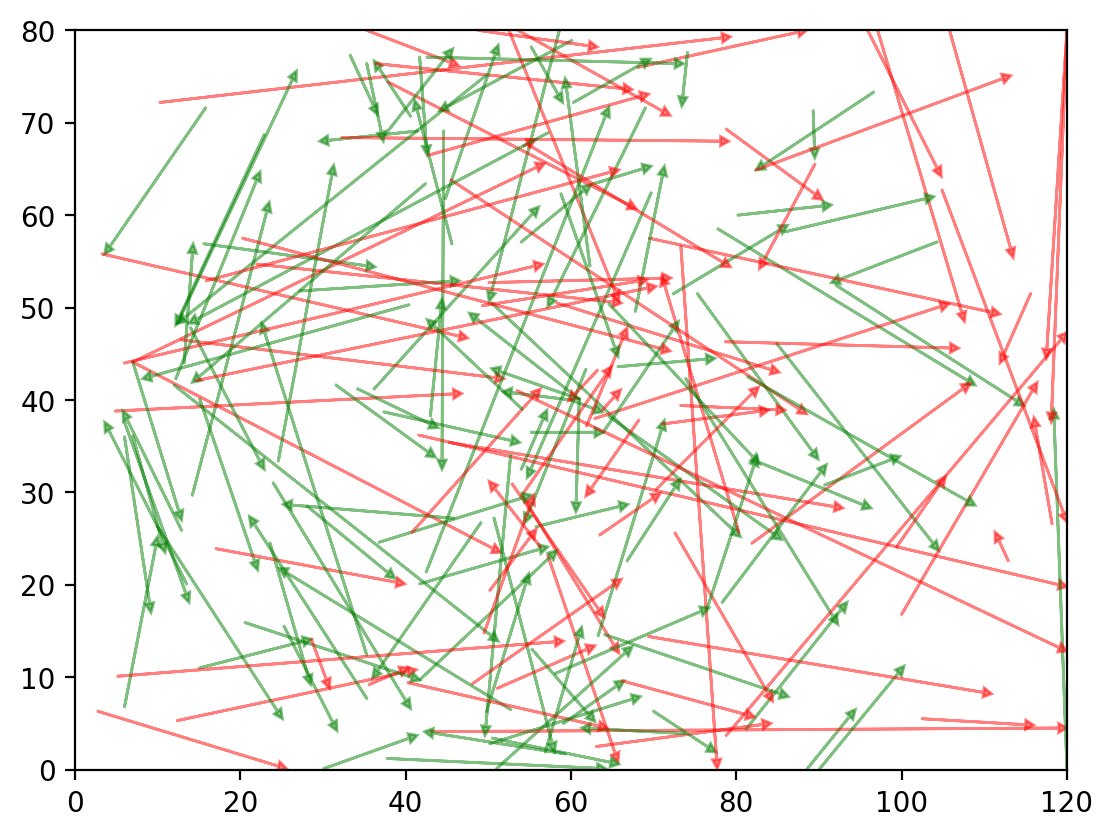

In [10]:
for x,y,end_x,end_y,outcome in df[["x", "y", "end_x", "end_y", "outcome"]].head(200).values:
    
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=1,
              head_length=1,
              color='green' if outcome == 1 else 'red',
              alpha=0.5,
              length_includes_head=True)
    
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

### Baseline Accuracy

#### What percentage of overall passes are completed?

In [11]:
baseline_accuracy = df['outcome'].mean()
print("Percentage of baseline_accuracy is {:.1f}%".format(baseline_accuracy*100))

Percentage of baseline_accuracy is 74.3%


## Basic Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

basic_model = LogisticRegression()

features = df[['angle', 'length']]
labels = df['outcome']

basic_model.fit(features, labels)

### Make Predictions

In [13]:
predictions = basic_model.predict_proba(features)[:, 1]
print("First 5 Predictions are {}".format(predictions[:5]))

First 5 Predictions are [0.79918277 0.60923596 0.70800187 0.74392033 0.85010227]


#### What percentage of these predictions are "correct"?

In [14]:
correct = 0

for i, prob in enumerate(predictions):
    pred = 1 if prob > 0.5 else 0
    
    if pred == labels[i]:
        correct += 1
        
print("{} of {} correct is {:.2f}".format(correct, len(labels), correct/len(labels)))
print("Percentage of Accurancy of Predictions is {:.2f}%".format(correct/len(labels) * 100))

59886 of 78635 correct is 0.76
Percentage of Accurancy of Predictions is 76.16%


### Sensitivity and Specificity

#### Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix

threshold = 0.5
confusion_matrix(labels, [1 if prob > threshold else 0 for prob in predictions])

# How to Read Confusion Matrix:

# True Negatives, False Positives
# False Negatives, True Positives

array([[ 2493, 17688],
       [ 1061, 57393]])

## Evaluating Predictions using ROC

ROC = Receiver Operating Characteristic

AUC = Area Under Curve

In [17]:
from sklearn import metrics

In [18]:
def draw_roc(labels, predictions):
    fpr, tpr, thresholds = metrics.roc_curve(labels, predictions, pos_label=1)
    auc = metrics.roc_auc_score(labels, predictions)
    plt.plot(fpr,tpr,label="AUC: {:.3f}".format(auc))
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()

### Perfect ROC

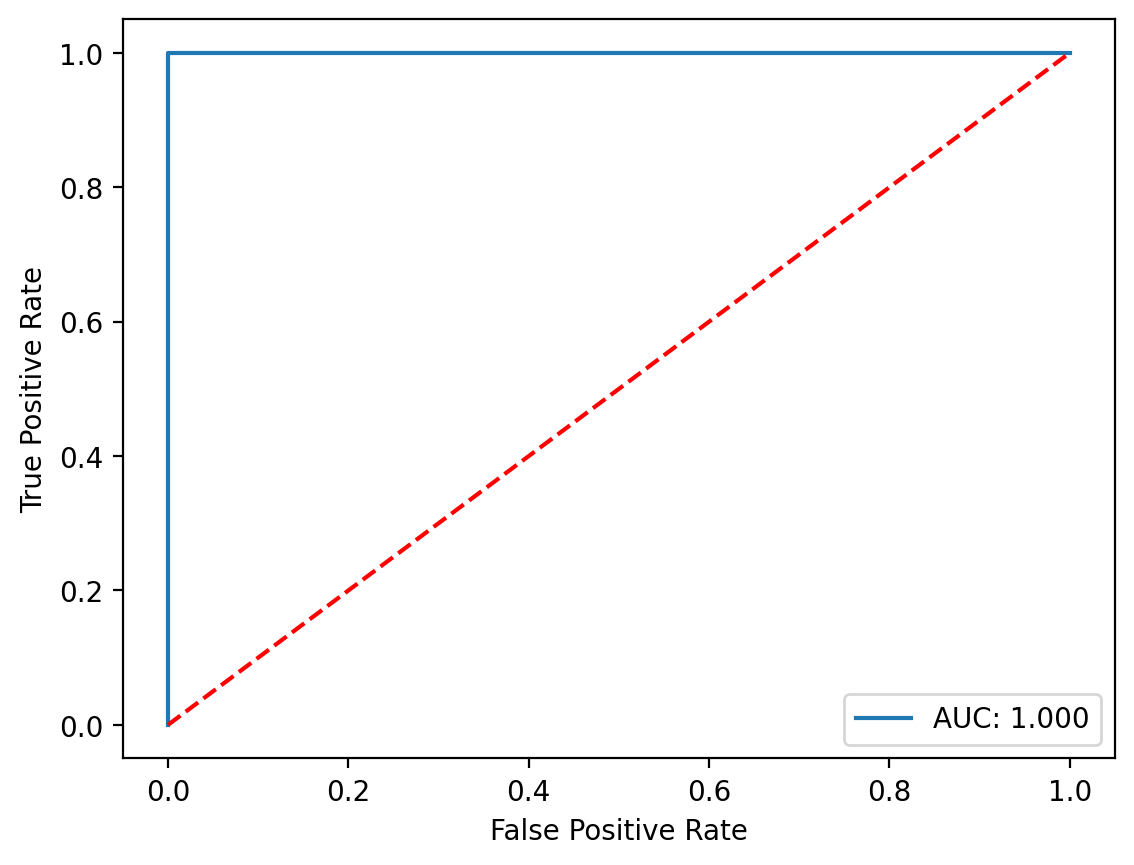

In [19]:
draw_roc(labels, labels)

### ROC for regression predictions

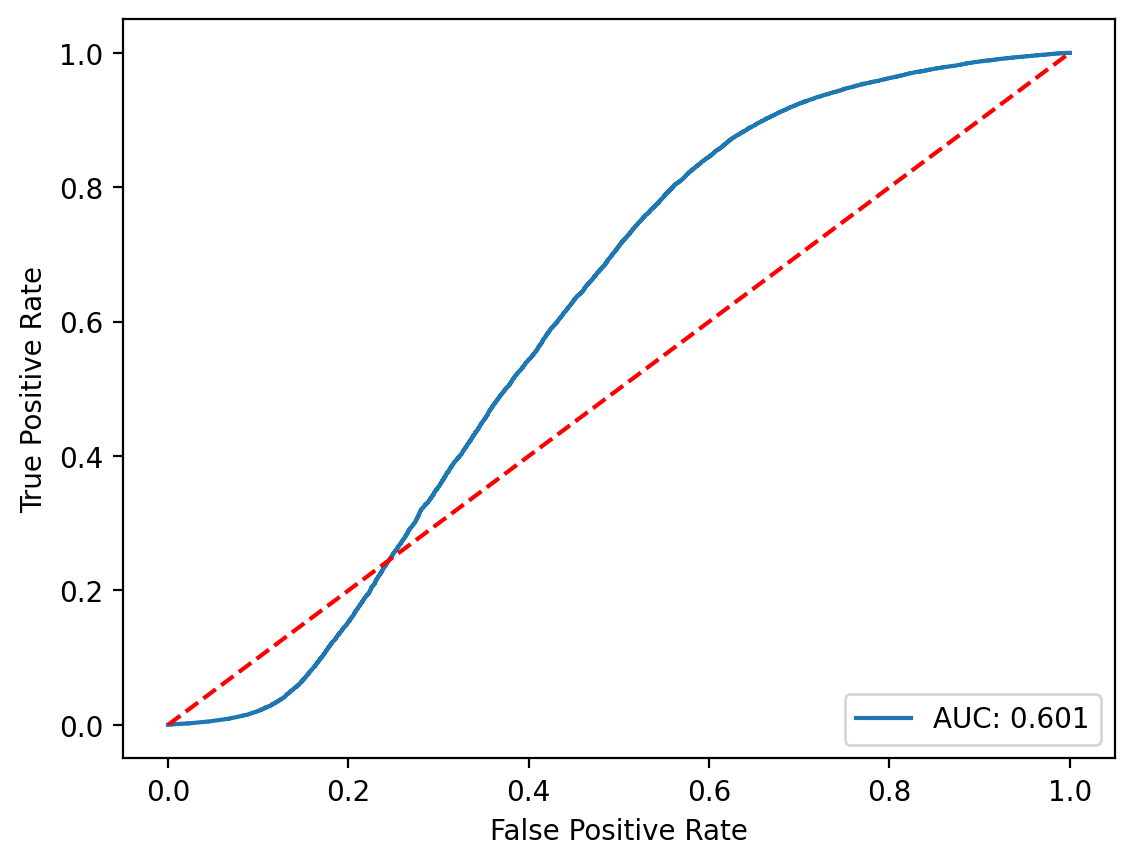

In [20]:
draw_roc(labels, predictions)

## Feature Engineering

#### Angle is provided in radians and ranges from -pi to +pi

In [21]:
# An angle of 0 is directly up the field

bins = np.linspace(-3.14,3.14,31)
df['angle_bin'] = pd.cut(df['angle'], bins=bins)

### Create new column in data frame

In [22]:
df['abs_angle'] = abs(df['angle'])
df.head()

,outcome,x,y,end_x,end_y,length,angle,angle_bin,abs_angle
0,1,61.0,40.1,47.7,49.4,16.228987,2.531372,"(2.512, 2.721]",2.531372
1,1,50.4,50.5,80.5,25.2,39.320477,-0.698971,"(-0.837, -0.628]",0.698971
2,0,80.3,25.7,71.0,53.4,29.219515,1.894711,"(1.884, 2.093]",1.894711
3,1,49.1,26.7,36.0,9.9,21.303755,-2.233075,"(-2.303, -2.093]",2.233075
4,0,35.6,9.2,40.3,11.0,5.032892,0.365747,"(0.209, 0.419]",0.365747


### Build another logistic regression model using new features

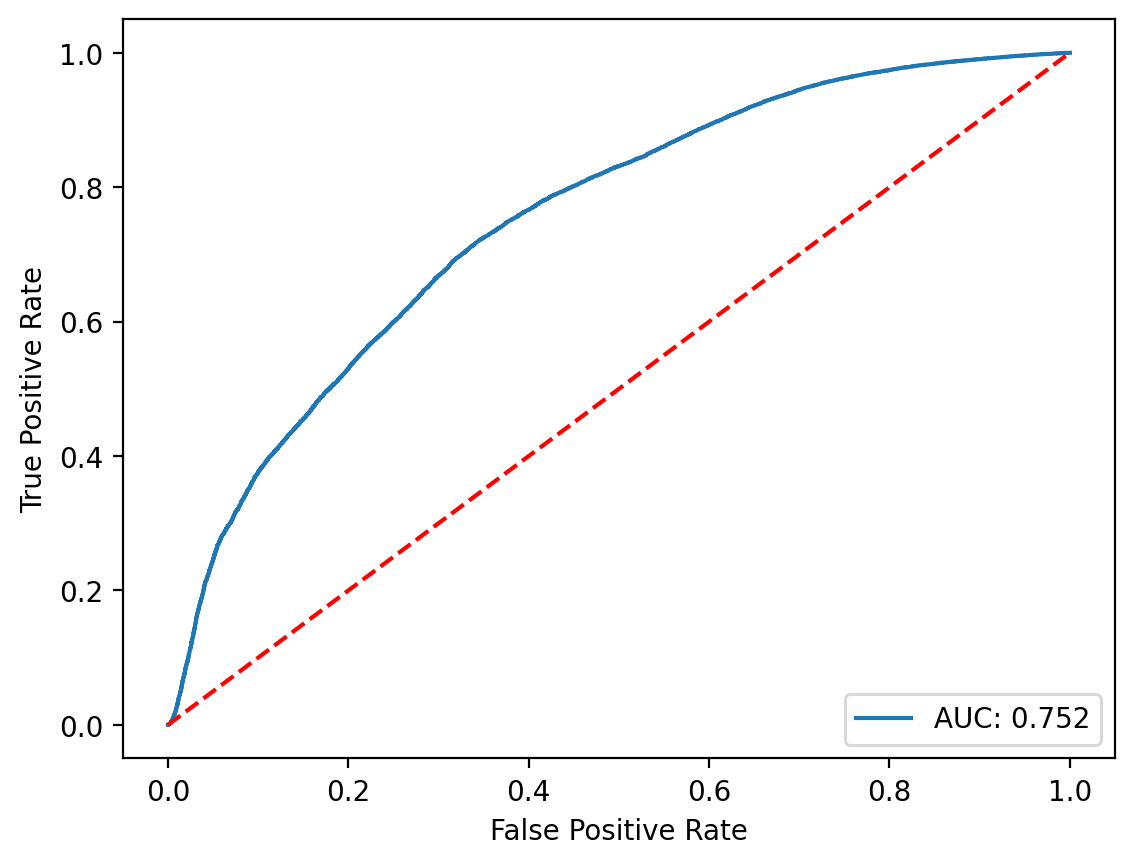

In [24]:
adjusted_model = LogisticRegression()

features = df[['abs_angle', 'length']]
labels = df['outcome']
basic_model.fit(features,labels)

predictions = basic_model.predict_proba(features)[:, 1]

draw_roc(labels, predictions)

## Build Piecewise Model

In [25]:
from sklearn.cluster import KMeans

#### Cluster all passes into 50 different types

In [26]:
cluster_model = KMeans(n_clusters=50).fit(df[['x','y','end_x','end_y']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



#### Store cluster classification as an additional column in data frame

In [27]:
df['cluster'] = cluster_model.predict(df[['x','y','end_x','end_y']])

### Plot all clusters

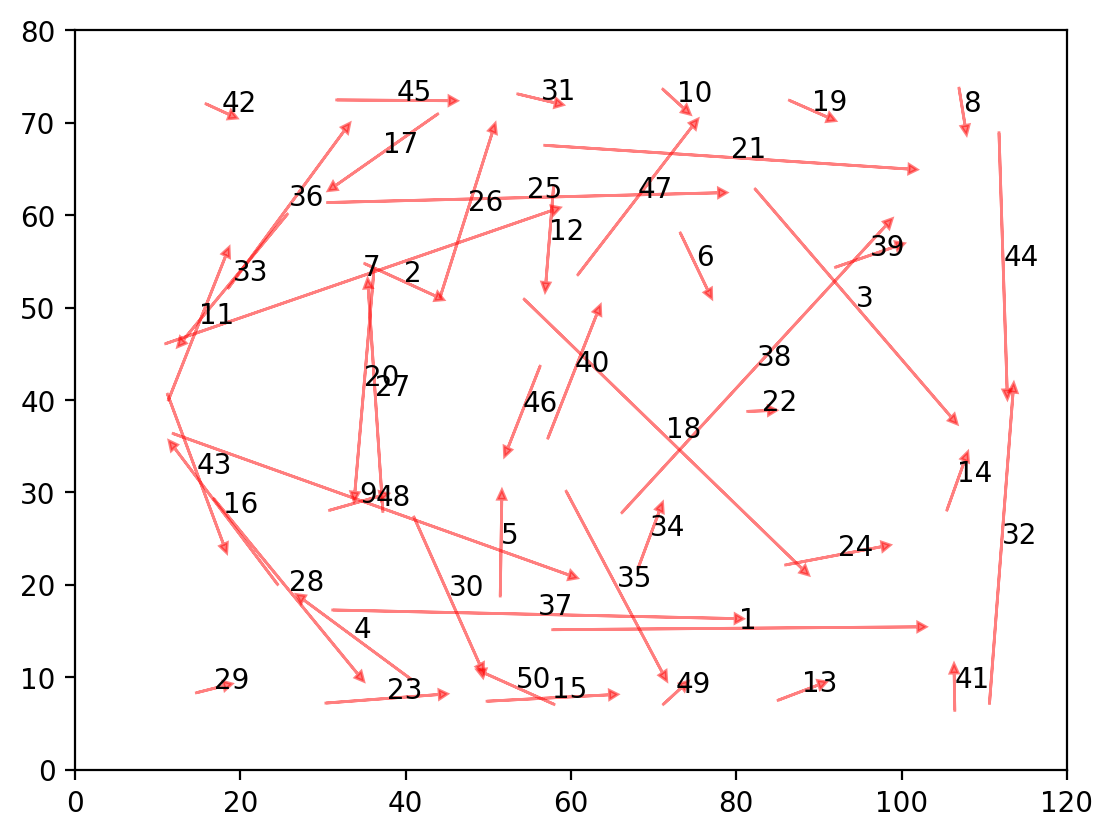

In [28]:
for i, (x, y, end_x, end_y) in enumerate(cluster_model.cluster_centers_):
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=1,
              head_length=1,
              color='red',
              alpha=0.5,
              length_includes_head=True)
    
    plt.text((x+end_x)/2, (y+end_y)/2, str(i+1))
    
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

In [29]:
df.head()

,outcome,x,y,end_x,end_y,length,angle,angle_bin,abs_angle,cluster
0,1,61.0,40.1,47.7,49.4,16.228987,2.531372,"(2.512, 2.721]",2.531372,39
1,1,50.4,50.5,80.5,25.2,39.320477,-0.698971,"(-0.837, -0.628]",0.698971,17
2,0,80.3,25.7,71.0,53.4,29.219515,1.894711,"(1.884, 2.093]",1.894711,21
3,1,49.1,26.7,36.0,9.9,21.303755,-2.233075,"(-2.303, -2.093]",2.233075,29
4,0,35.6,9.2,40.3,11.0,5.032892,0.365747,"(0.209, 0.419]",0.365747,22


### Build an individualized logistic regression model for each pass type

In [30]:
models = {}

for i, e in enumerate(cluster_model.cluster_centers_):
    passes_in_cluster = df[df['cluster'] == i]
    
    models[i] = LogisticRegression()
    
    features = passes_in_cluster[['abs_angle', 'length']]
    labels = passes_in_cluster['outcome']
    
    models[i].fit(features,labels)

In [32]:
def get_prediction(cluster, abs_angle, length):
    v = np.array([abs_angle, length]).reshape(1,-1)    
    return models[cluster].predict_proba(v)[:, 1]

### Vectorize get prediction funtion for fast results

In [33]:
get_prediction = np.vectorize(get_prediction)


### Create additional column in data frame to store predictions

In [34]:
df['predictions'] = get_prediction(df['cluster'], df['abs_angle'], df['length'])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

In [35]:
df.head()

,outcome,x,y,end_x,end_y,length,angle,angle_bin,abs_angle,cluster,predictions
0,1,61.0,40.1,47.7,49.4,16.228987,2.531372,"(2.512, 2.721]",2.531372,39,0.979547
1,1,50.4,50.5,80.5,25.2,39.320477,-0.698971,"(-0.837, -0.628]",0.698971,17,0.469794
2,0,80.3,25.7,71.0,53.4,29.219515,1.894711,"(1.884, 2.093]",1.894711,21,0.919039
3,1,49.1,26.7,36.0,9.9,21.303755,-2.233075,"(-2.303, -2.093]",2.233075,29,0.983982
4,0,35.6,9.2,40.3,11.0,5.032892,0.365747,"(0.209, 0.419]",0.365747,22,0.718357


### Draw ROC of final piecewise model

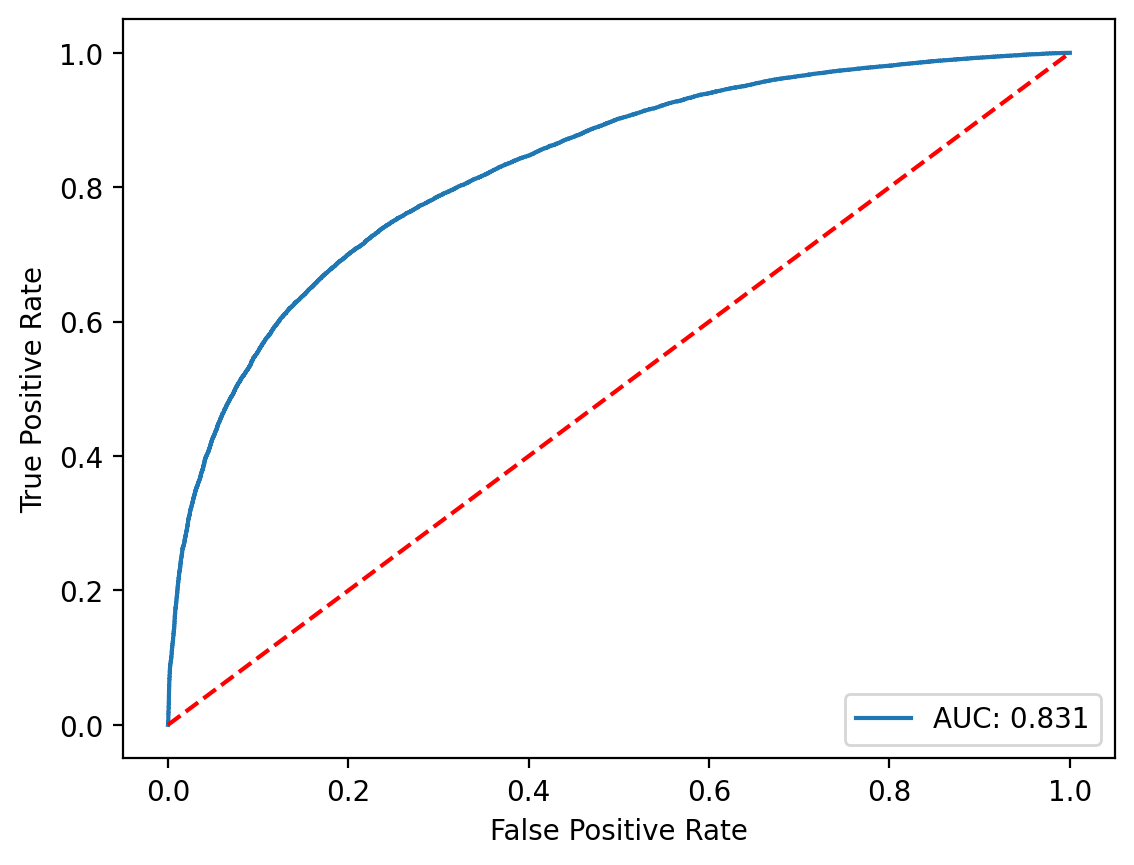

In [36]:
draw_roc(df['outcome'], df['predictions'])